In [1]:
!pip install scikit-plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


funzioni utili

In [2]:
def result_pred(y_true, y_pred):
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)    
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred)
    print("Numero di campioni correttamente correlati: ", accuracy)    
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)   
    print("____________________________________________")    

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")    

    # Calcolo della specificity
    print("**** Calcolo della specificity *****")
    specificity = tn / (tn+fp)
    print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")   
    
    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall, 
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")   
    
    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))
    
    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")

In [3]:
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")    
    print(roc_auc_score(y_test, y_score[:,1]))    
    
    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()
    
    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()
    

    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()
    
    
    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")    
    plot_lift_curve(y_test, y_score)
    plt.show()

In [4]:
def plt_single_perceptron(name_csv, pnl):
    df = pd.read_csv(name_csv)
    fig = plt.figure(figsize=(16,8))
    fig.canvas.manager.full_screen_toggle()

    fig.suptitle('Single Perceptron', fontsize=15, fontweight='bold')
    penalty = pnl
    df = df.loc[(df.penalty == penalty)][['f1','std_dev', 'alpha','tol']]
    pivot = df.pivot('alpha','tol', 'f1')
    labels = pivot.values.astype(str)

    x = 0
    for i in range(0, pivot.shape[0]):
        for j in range(0, pivot.shape[1]):
            labels[i,j] = str(labels[i,j])[:5] + "\n+/- " + "{0:.3f}".format(df['std_dev'].iloc[x])
            x += 1

    sns.heatmap(pivot, cmap="YlGnBu", annot=labels, fmt="", cbar=False, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()

datasets e normalizzazione 

In [5]:
df_train = pd.read_csv("/content/Train_NOoutliers")
df_train = df_train.drop(columns=['Unnamed: 0'], axis = 1)
df_train = df_train.drop(columns=['outlier_detection'], axis = 1)
df_test = pd.read_csv("/content/Test_ripulito")
df_test = df_test.drop(columns=['Unnamed: 0'], axis = 1)

In [6]:
df_train_final = df_train[(df_train.emotion != "neutral") & (df_train.emotion != "surprised")]
df_test_final = df_test[(df_test.emotion != "neutral") & (df_test.emotion != "surprised")]

In [7]:
train_positive = []
for value in df_train_final['emotion']:
  if((value == 'happy') | (value == 'calm')):
    train_positive.append(1)
  else:
    train_positive.append(0)

In [8]:
test_positive = []
for value in df_test_final['emotion']:
  if((value == 'happy') | (value == 'calm')):
    test_positive.append(1)
  else:
    test_positive.append(0)

In [9]:
df_train_final = df_train_final.assign(positive = train_positive)
df_test_final = df_test_final.assign(positive = test_positive)
#1 se emozioni positive 
#0 se emozioni negative
#neutral e surprised NON incluse

In [10]:
X_train = df_train_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_train = df_train_final[['positive']]
X_test = df_test_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_test = df_test_final[['positive']]

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# make sure data are np.ndarray
y_train = np.array(y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

NEURAL NETWORKS

Single Perceptron

In [13]:
from sklearn.linear_model import Perceptron
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Set the parameters by cross-validation

tuned_parameters = {
    'penalty': ['l2','l1','elasticnet'],
    'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
    'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42,shuffle = True)


#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = Perceptron()

    #if (score == "recall"):
    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)

    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")
    
    f1_val = []
    for i in means:
        f1_val.append("%0.3f" % i)
    
    std_val = []
    for i in stds:
        std_val.append("%0.3f" % (i*2))
    
    par1 = []
    par2 = []
    par3 = []
    for i in clf.cv_results_['params']:
        par1.append(i["alpha"])
        par2.append(i["penalty"])
        par3.append(i["tol"])
    data = {'f1': f1_val, "std_dev":std_val, "alpha":par1, "penalty":par2, "tol": par3}

    res = pd.DataFrame (data, columns = ["f1", "std_dev", "alpha", "penalty", "tol"])
    res.to_csv('single_perceptron_results.csv', index=False)

# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'alpha': 0.001, 'penalty': 'l1', 'tol': 0.1}

Grid scores on development set:

0.547 (+/-0.080) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.1}
0.547 (+/-0.080) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.01}
0.547 (+/-0.080) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.001}
0.547 (+/-0.080) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.0001}
0.547 (+/-0.080) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-05}
0.547 (+/-0.080) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-06}
0.491 (+/-0.101) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.1}
0.491 (+/-0.101) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.01}
0.491 (+/-0.101) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.001}
0.491 (+/-0.101) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.0001}
0.491 (+/-0.101) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-05}
0.491 (+/-0.101) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-0

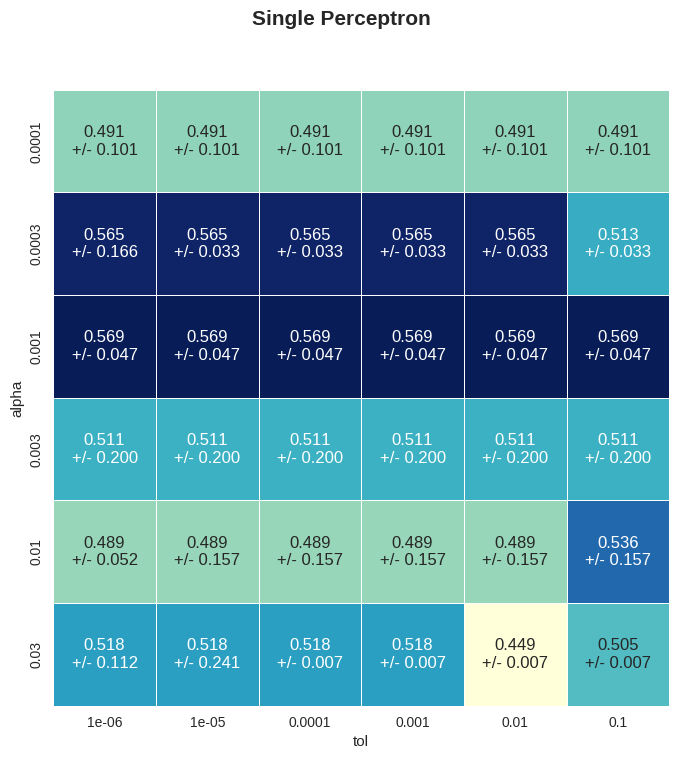

In [15]:
#{'alpha': 0.001, 'penalty': 'l1', 'tol': 0.1} --> best parameters con f1
plt_single_perceptron("single_perceptron_results.csv", 'l1')

**** Matrice di Confusione *****
 True negative: 208 False negative: 78
 True positive: 114 False positive: 128
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.6098
Numero di campioni correttamente correlati:  0.6098484848484849
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.4711
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.5938
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.6190
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.5253
____________________________________________
              precision    recal

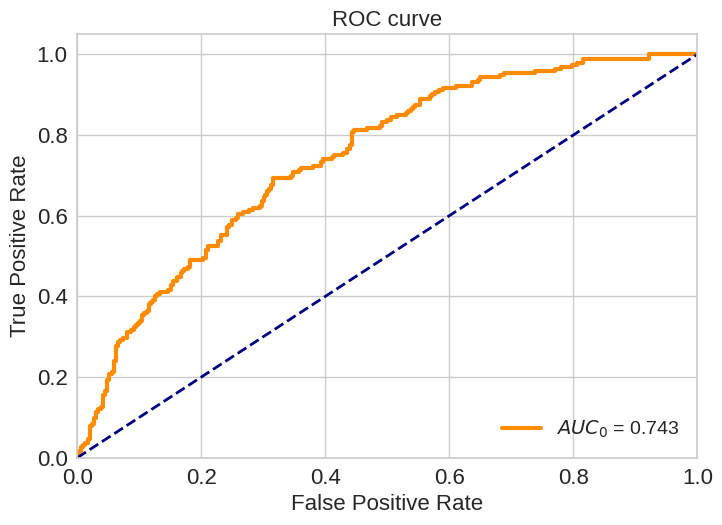

____________________________________
****** VALORE DI AUC *******
0.7430555555555556
____________________________________
****** ROC CURVE: con metodo diretto *******


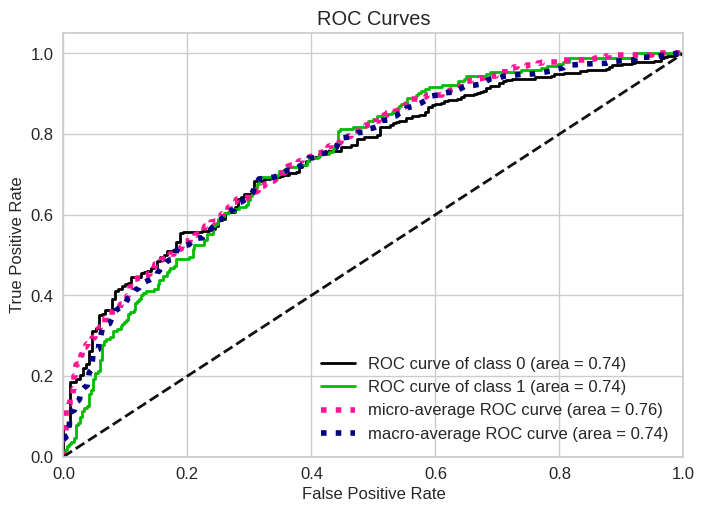

____________________________________
****** Precision recall: con metodo diretto *******


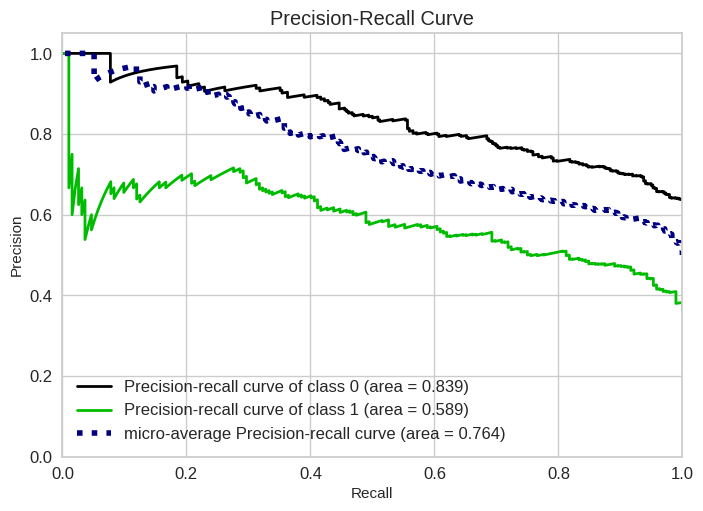

____________________________________
****** Cumulative gain: con metodo diretto *******


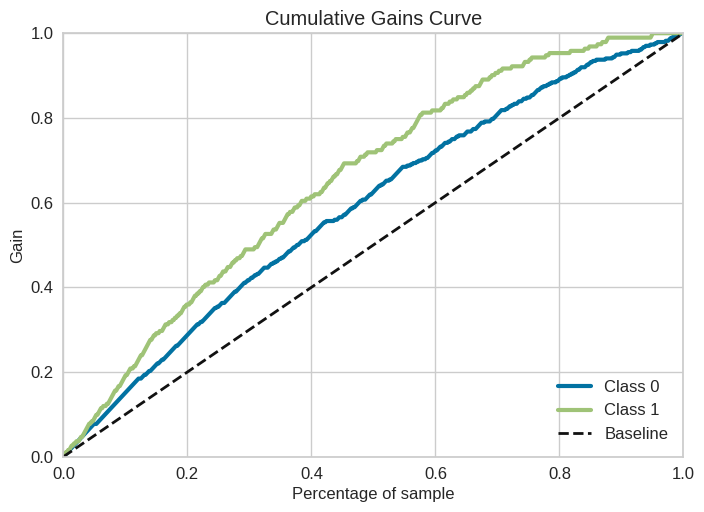

____________________________________
****** Lift curve: con metodo diretto *******


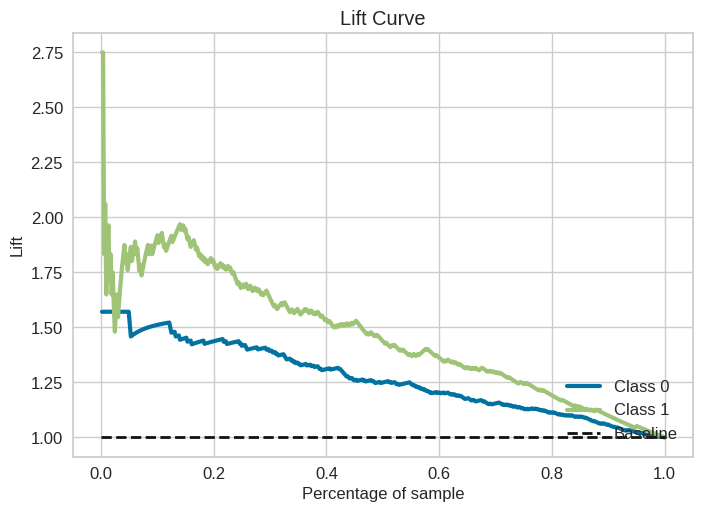

In [15]:
#{'alpha': 0.001, 'penalty': 'l1', 'tol': 0.1} --> best parameters con f1
from sklearn.calibration import CalibratedClassifierCV
clf = Perceptron(alpha = 0.001, penalty = "l1", tol=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
#y_score = clf.predict_proba(X_test)
cclf = CalibratedClassifierCV(base_estimator=Perceptron(alpha = 0.001, penalty = "l1", tol=0.1), cv=5)
cclf.fit(X_train, y_train)
y_pred = cclf.predict(X_test)
y_score = cclf.predict_proba(X_test)
result_pred(y_test, y_pred)
#plot_res_linearSVC(y_pred, y_score[:, 1], y_test)
plot_res(y_pred, y_score, y_test)

vediamo sbilanciamento iniziale nel train e nel test

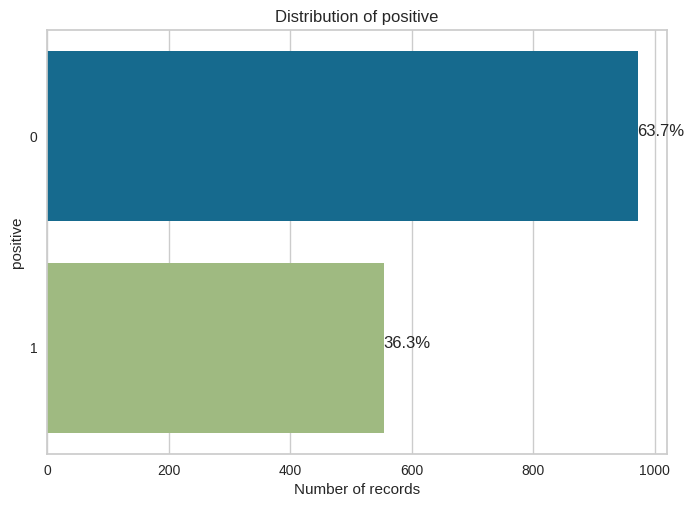

In [16]:
class_name = 'positive'
#sbilanciamento train
attributes = [col for col in df_train_final.columns if col != class_name]
X = df_train_final[attributes].values
y = df_train_final[class_name]

ax = sns.countplot(y="positive", data=df_train_final)
plt.title('Distribution of positive')
plt.xlabel('Number of records')
total = len(df_train_final['positive'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

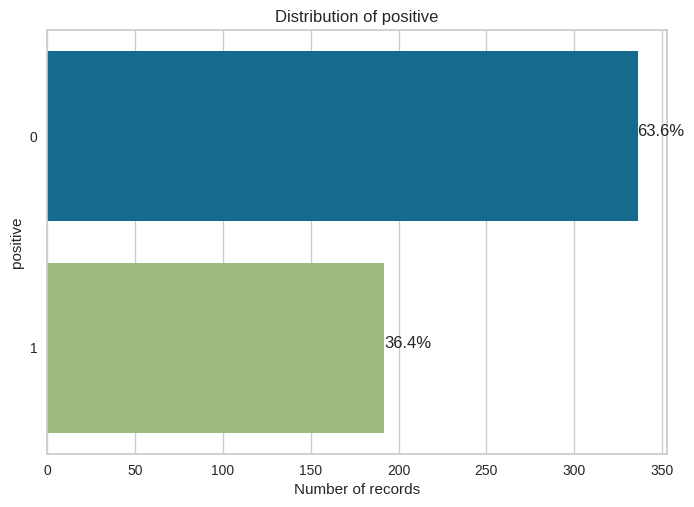

In [17]:
attributes2 = [col for col in df_test_final.columns if col != class_name]
X = df_test_final[attributes2].values
y = df_test_final[class_name]

ax = sns.countplot(y="positive", data=df_test_final)
plt.title('Distribution of positive')
plt.xlabel('Number of records')
total = len(df_test_final['positive'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

Single Perceptron con Oversampling

In [18]:
X_train = df_train_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_train = df_train_final[['positive']]
X_test = df_test_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_test = df_test_final[['positive']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ros = RandomOverSampler(random_state=42)
X_res_train, y_res_train = ros.fit_resample(X_train, y_train['positive']) #x_res e y_res nuovi x_train e y_train
print('Resampled dataset shape %s' % Counter(y_res_train))

Resampled dataset shape Counter({1: 972, 0: 972})


In [19]:
tuned_parameters = {
    'penalty': ['l2','l1','elasticnet'],
    'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
    'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42,shuffle = True)


#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = Perceptron()

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)

    clf.fit(X_res_train, y_res_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'alpha': 0.001, 'penalty': 'l1', 'tol': 0.1}

Grid scores on development set:

0.612 (+/-0.039) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.1}
0.612 (+/-0.039) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.01}
0.612 (+/-0.039) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.001}
0.612 (+/-0.039) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.0001}
0.612 (+/-0.039) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-05}
0.612 (+/-0.039) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-06}
0.662 (+/-0.062) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.1}
0.662 (+/-0.062) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.01}
0.662 (+/-0.062) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.001}
0.662 (+/-0.062) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.0001}
0.662 (+/-0.062) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-05}
0.662 (+/-0.062) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-0

In [20]:
#{'alpha': 0.001, 'penalty': 'l1', 'tol': 0.1}
clf = Perceptron(alpha = 0.001, penalty = "l1", tol=0.1)
clf.fit(X_res_train, y_res_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)

**** Matrice di Confusione *****
 True negative: 218 False negative: 63
 True positive: 129 False positive: 118
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.6572
Numero di campioni correttamente correlati:  0.6571969696969697
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.5223
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.6719
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.6488
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.5877
____________________________________________
              precision    recal

Single Perc con Undersampling 

In [21]:
X_train = df_train_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_train = df_train_final[['positive']]
X_test = df_test_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_test = df_test_final[['positive']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ros =RandomUnderSampler(random_state=42)
X_res_train, y_res_train = ros.fit_resample(X_train, y_train['positive']) #x_res e y_res nuovi x_train e y_train
print('Resampled dataset shape %s' % Counter(y_res_train))

tuned_parameters = {
    'penalty': ['l2','l1','elasticnet'],
    'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
    'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42, shuffle = True)


#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = Perceptron()

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)

    clf.fit(X_res_train, y_res_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

Resampled dataset shape Counter({0: 554, 1: 554})
# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'alpha': 0.0003, 'penalty': 'l1', 'tol': 0.01}

Grid scores on development set:

0.648 (+/-0.034) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.1}
0.648 (+/-0.034) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.01}
0.648 (+/-0.034) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.001}
0.648 (+/-0.034) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.0001}
0.648 (+/-0.034) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-05}
0.648 (+/-0.034) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-06}
0.642 (+/-0.032) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.1}
0.653 (+/-0.050) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.01}
0.653 (+/-0.050) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.001}
0.653 (+/-0.050) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.0001}
0.653 (+/-0.050) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-05}
0.653 (+/-0.050

In [22]:
#{'alpha': 0.0003, 'penalty': 'l1', 'tol': 0.01}
clf = Perceptron(alpha = 0.0003, penalty = "l1", tol=0.01)
clf.fit(X_res_train, y_res_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)

**** Matrice di Confusione *****
 True negative: 226 False negative: 57
 True positive: 135 False positive: 110
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.6837
Numero di campioni correttamente correlati:  0.6837121212121212
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.5510
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.7031
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.6726
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.6178
____________________________________________
              precision    recal

MULTILAYER PERCERPTON

In [23]:
from sklearn.neural_network import MLPClassifier
X_train = df_train_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_train = df_train_final[['positive']]
X_test = df_test_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_test = df_test_final[['positive']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42, shuffle = True)

tuned_parameters = {
    #'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    #'alpha': 10.0 ** -np.arange(1, 7), 
    'momentum' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9],
    'hidden_layer_sizes':[(12, 23, 11,), (23, 43, 32,), (128, 64, 32,)],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = MLPClassifier(solver = 'sgd')

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")
    
    f1_val = []
    for i in means:
        f1_val.append("%0.3f" % i)
    
    std_val = []
    for i in stds:
        std_val.append("%0.3f" % (i*2))
    
    par1 = []
    par2 = []
    par3 = []
    for i in clf.cv_results_['params']:
        par1.append(i["hidden_layer_sizes"])
        par2.append(i["momentum"])
        par3.append(i["learning_rate"])
    data = {'f1': f1_val, "std_dev":std_val, "hidden_layer_sizes":par1, "momentum":par2, "learning_rate": par3}

    res = pd.DataFrame (data, columns = ["f1", "std_dev", "hidden_layer_sizes", "momentum", "learning_rate"])
    res.to_csv('multiple_perceptron_results.csv', index=False)

# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'adaptive', 'momentum': 0.9}

Grid scores on development set:

0.234 (+/-0.293) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0}
0.167 (+/-0.313) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.1}
0.244 (+/-0.267) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.2}
0.117 (+/-0.021) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.3}
0.262 (+/-0.054) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.4}
0.220 (+/-0.203) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.5}
0.318 (+/-0.241) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.7}
0.525 (+/-0.029) for {'hidden_layer_sizes': (12, 23, 11), 'learning_r

**** Matrice di Confusione *****
 True negative: 232 False negative: 65
 True positive: 127 False positive: 104
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.6799
Numero di campioni correttamente correlati:  0.6799242424242424
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.5498
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.6615
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.6905
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.6005
____________________________________________
              precision    recal

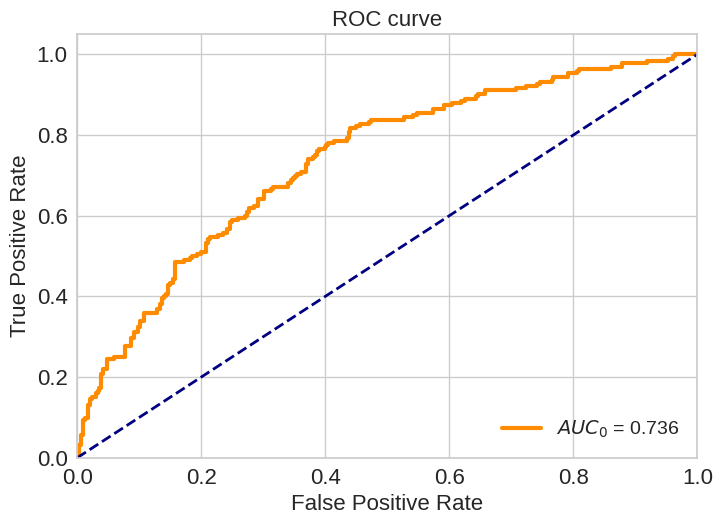

____________________________________
****** VALORE DI AUC *******
0.7361576140873016
____________________________________
****** ROC CURVE: con metodo diretto *******


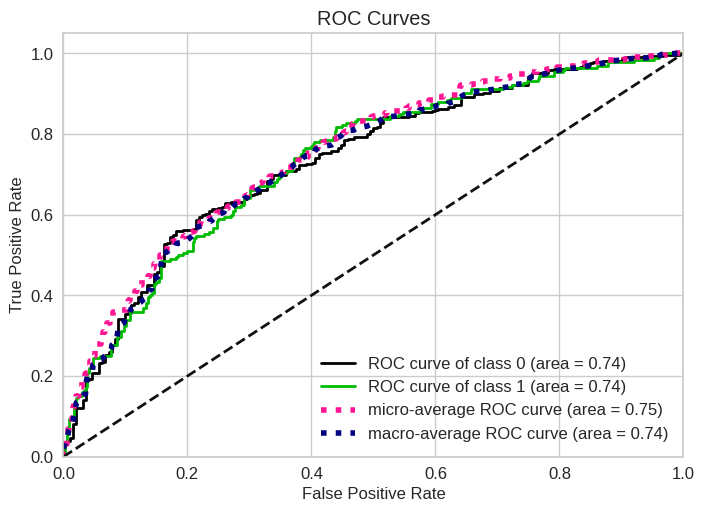

____________________________________
****** Precision recall: con metodo diretto *******


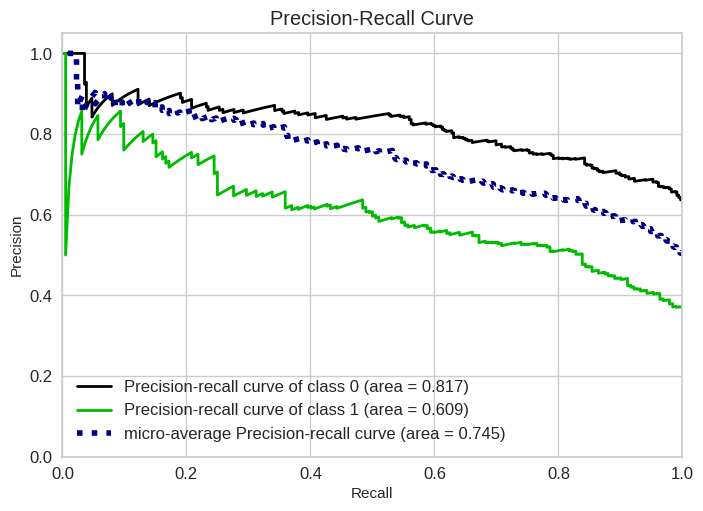

____________________________________
****** Cumulative gain: con metodo diretto *******


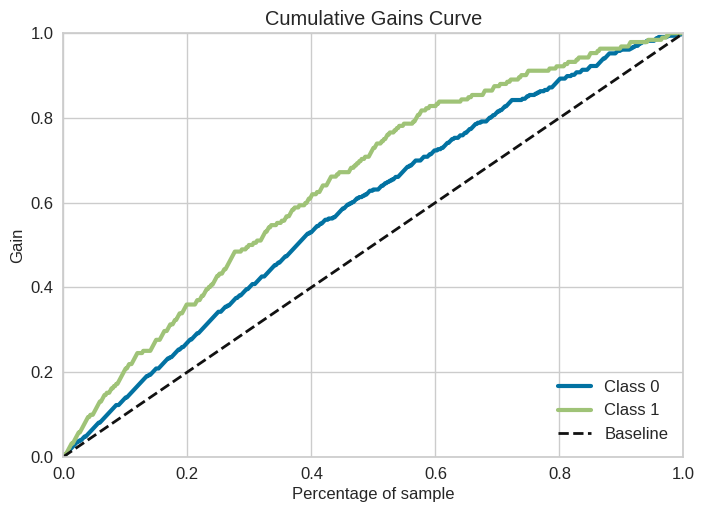

____________________________________
****** Lift curve: con metodo diretto *******


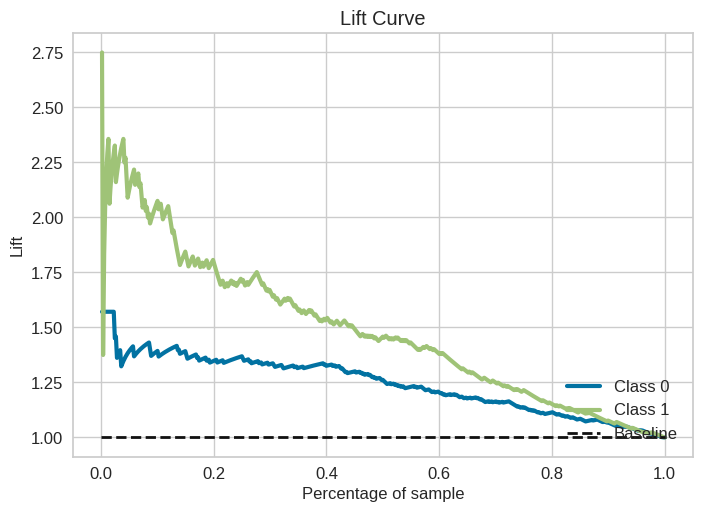

In [25]:
#{'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'adaptive', 'momentum': 0.9}
clf = MLPClassifier(solver = 'sgd', momentum = 0.9, learning_rate = 'adaptive' , hidden_layer_sizes= (128, 64, 32))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
#y_score = clf.predict_proba(X_test)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

Multilayer con oversampling 

In [26]:
import warnings
from sklearn.exceptions import ConvergenceWarning

X_train = df_train_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_train = df_train_final[['positive']]
X_test = df_test_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_test = df_test_final[['positive']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ros = RandomOverSampler(random_state=42)
X_res_train, y_res_train = ros.fit_resample(X_train, y_train['positive']) #x_res e y_res nuovi x_train e y_train
print('Resampled dataset shape %s' % Counter(y_res_train))

# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42, shuffle = True)

tuned_parameters = {
    #'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    #'alpha': 10.0 ** -np.arange(1, 7), 
    'momentum' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9],
    'hidden_layer_sizes':[(12, 23, 11,), (23, 43, 32,), (128, 64, 32,)],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = MLPClassifier(solver = 'sgd')

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X_res_train, y_res_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")
    
    f1_val = []
    for i in means:
        f1_val.append("%0.3f" % i)
    
    std_val = []
    for i in stds:
        std_val.append("%0.3f" % (i*2))
    
    par1 = []
    par2 = []
    par3 = []
    for i in clf.cv_results_['params']:
        par1.append(i["hidden_layer_sizes"])
        par2.append(i["momentum"])
        par3.append(i["learning_rate"])
    data = {'f1': f1_val, "std_dev":std_val, "hidden_layer_sizes":par1, "momentum":par2, "learning_rate": par3}

    res = pd.DataFrame (data, columns = ["f1", "std_dev", "hidden_layer_sizes", "momentum", "learning_rate"])
    res.to_csv('multiple_perceptron_results.csv', index=False)

Resampled dataset shape Counter({1: 972, 0: 972})
# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'adaptive', 'momentum': 0.9}

Grid scores on development set:

0.570 (+/-0.104) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0}
0.559 (+/-0.137) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.1}
0.628 (+/-0.032) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.2}
0.568 (+/-0.069) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.3}
0.608 (+/-0.083) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.4}
0.642 (+/-0.030) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.5}
0.652 (+/-0.019) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.7}
0.736 (+/-0.087) fo

**** Matrice di Confusione *****
 True negative: 247 False negative: 70
 True positive: 122 False positive: 89
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.6989
Numero di campioni correttamente correlati:  0.6988636363636364
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.5782
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.6354
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.7351
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.6055
____________________________________________
              precision    recall

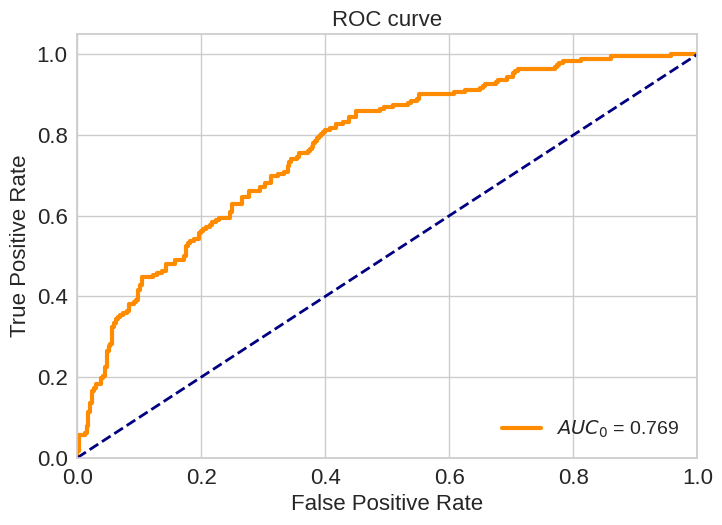

____________________________________
****** VALORE DI AUC *******
0.7691747271825395
____________________________________
****** ROC CURVE: con metodo diretto *******


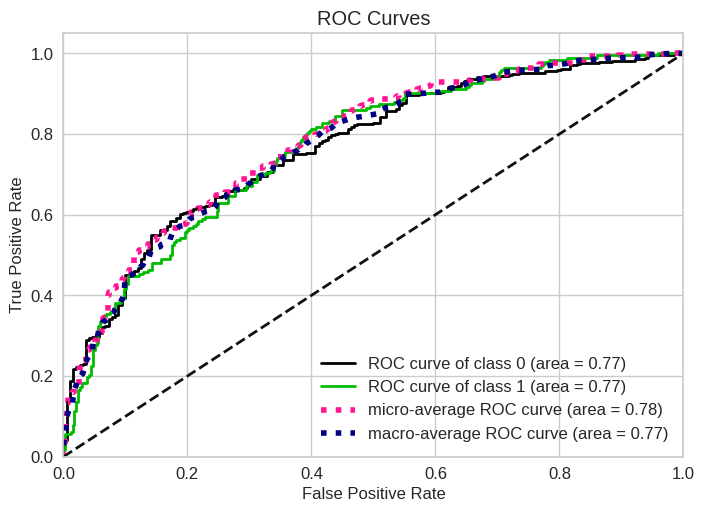

____________________________________
****** Precision recall: con metodo diretto *******


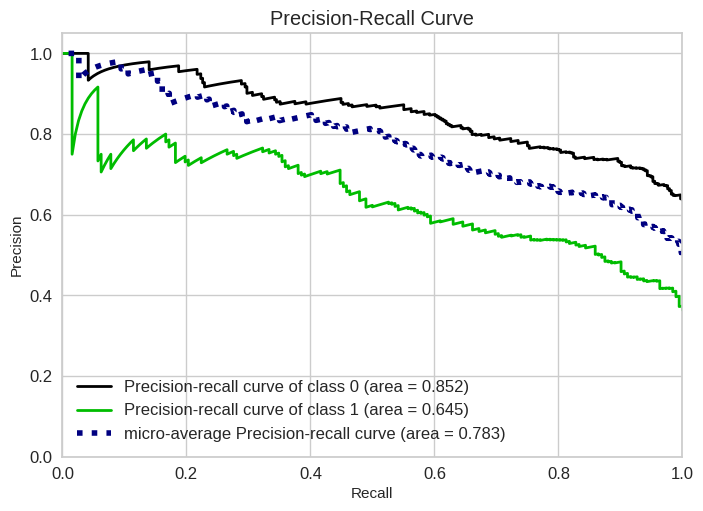

____________________________________
****** Cumulative gain: con metodo diretto *******


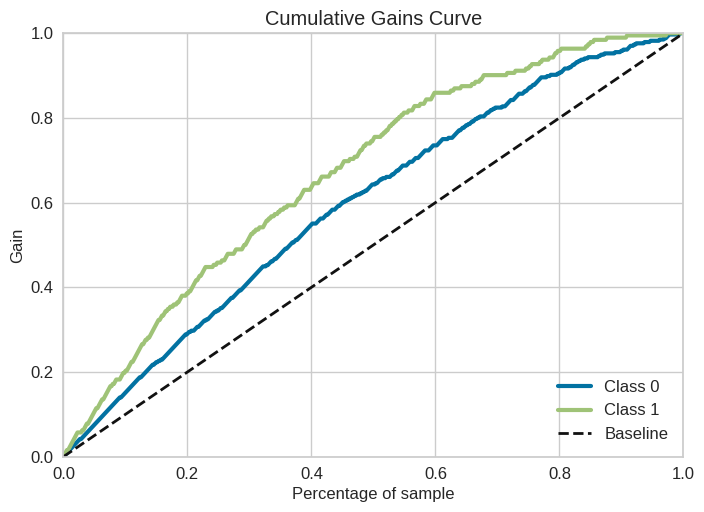

____________________________________
****** Lift curve: con metodo diretto *******


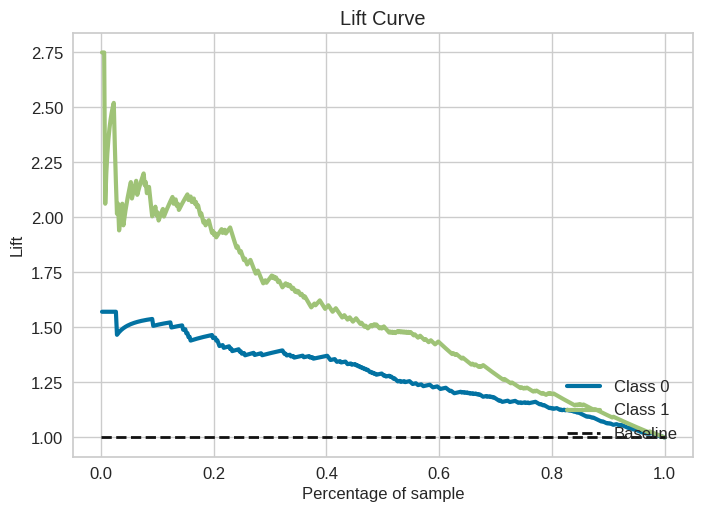

In [27]:
#{'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'adaptive', 'momentum': 0.9}
clf = MLPClassifier(solver = 'sgd', momentum = 0.9, learning_rate = 'adaptive' , hidden_layer_sizes=(128, 64, 32))
clf.fit(X_res_train, y_res_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
#y_score = clf.predict_proba(X_test)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

Multilayer con undersampling

In [28]:
import warnings
from sklearn.exceptions import ConvergenceWarning

X_train = df_train_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_train = df_train_final[['positive']]
X_test = df_test_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_test = df_test_final[['positive']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ros =RandomUnderSampler(random_state=42)
X_res_train, y_res_train = ros.fit_resample(X_train, y_train['positive']) #x_res e y_res nuovi x_train e y_train
print('Resampled dataset shape %s' % Counter(y_res_train))

# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42, shuffle = True)

tuned_parameters = {
    #'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    #'alpha': 10.0 ** -np.arange(1, 7), 
    'momentum' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9],
    'hidden_layer_sizes':[(12, 23, 11,), (23, 43, 32,), (128, 64, 32,)],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = MLPClassifier(solver = 'sgd')

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X_res_train, y_res_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")
    
    f1_val = []
    for i in means:
        f1_val.append("%0.3f" % i)
    
    std_val = []
    for i in stds:
        std_val.append("%0.3f" % (i*2))
    
    par1 = []
    par2 = []
    par3 = []
    for i in clf.cv_results_['params']:
        par1.append(i["hidden_layer_sizes"])
        par2.append(i["momentum"])
        par3.append(i["learning_rate"])
    data = {'f1': f1_val, "std_dev":std_val, "hidden_layer_sizes":par1, "momentum":par2, "learning_rate": par3}

    res = pd.DataFrame (data, columns = ["f1", "std_dev", "hidden_layer_sizes", "momentum", "learning_rate"])
    res.to_csv('multiple_perceptron_results.csv', index=False)

Resampled dataset shape Counter({0: 554, 1: 554})
# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'adaptive', 'momentum': 0.9}

Grid scores on development set:

0.411 (+/-0.487) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0}
0.575 (+/-0.260) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.1}
0.595 (+/-0.073) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.2}
0.549 (+/-0.210) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.3}
0.478 (+/-0.404) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.4}
0.544 (+/-0.063) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.5}
0.608 (+/-0.099) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.7}
0.678 (+/-0.063) fo

**** Matrice di Confusione *****
 True negative: 222 False negative: 53
 True positive: 139 False positive: 114
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.6837
Numero di campioni correttamente correlati:  0.6837121212121212
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.5494
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.7240
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.6607
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.6247
____________________________________________
              precision    recal

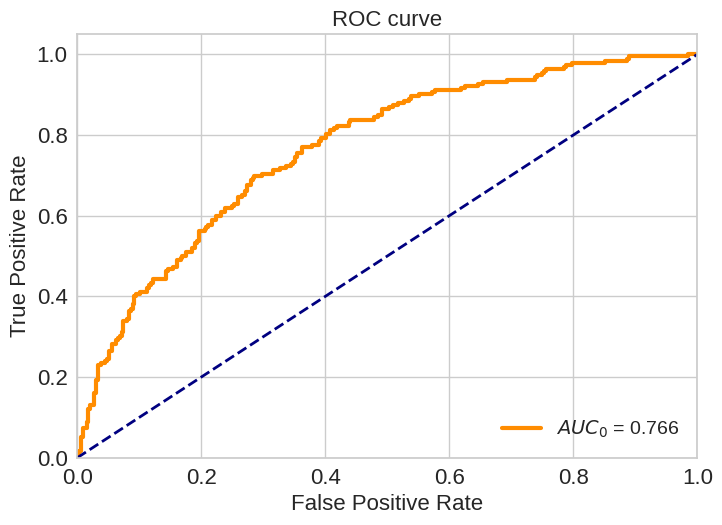

____________________________________
****** VALORE DI AUC *******
0.766384548611111
____________________________________
****** ROC CURVE: con metodo diretto *******


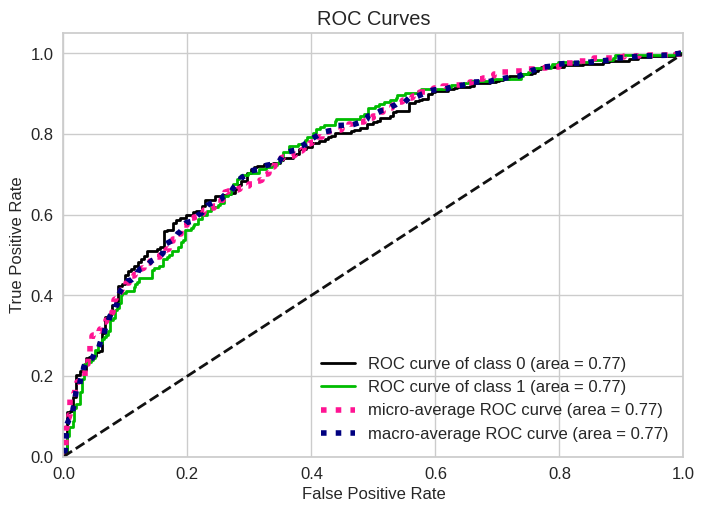

____________________________________
****** Precision recall: con metodo diretto *******


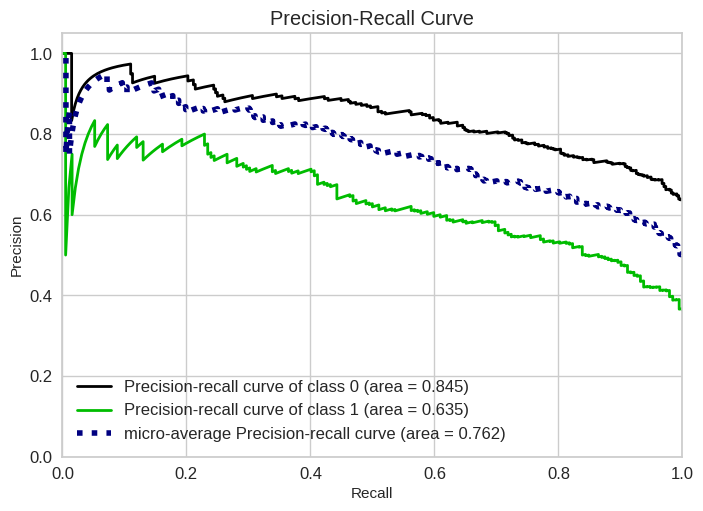

____________________________________
****** Cumulative gain: con metodo diretto *******


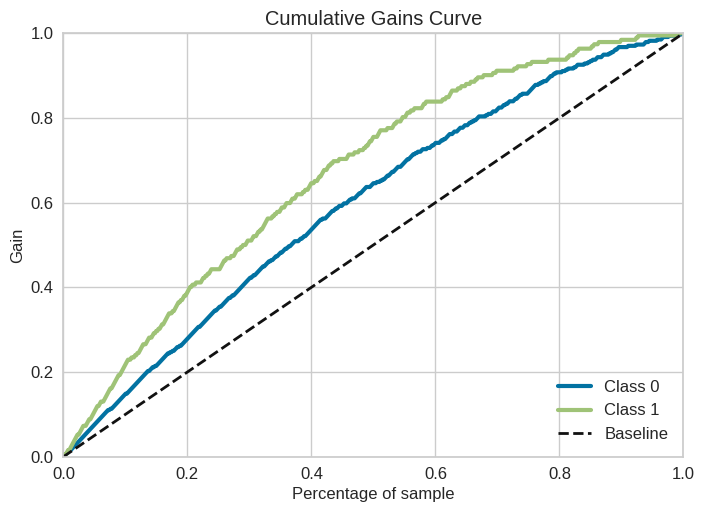

____________________________________
****** Lift curve: con metodo diretto *******


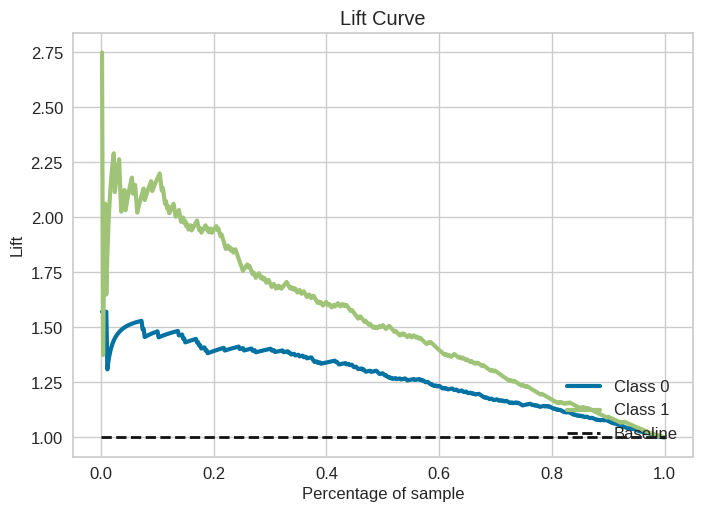

In [29]:
#{'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'adaptive', 'momentum': 0.9}
clf = MLPClassifier(solver = 'sgd', momentum = 0.9, learning_rate = 'adaptive' , hidden_layer_sizes=(128, 64, 32))
clf.fit(X_res_train, y_res_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
#y_score = clf.predict_proba(X_test)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)